In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(69)
%matplotlib inline

In [ ]:
movie_df = pd.read_csv('data/movies_c.txt', delimiter='\t', header=None,
                       names=["Movie Id", "Movie Title", "Unknown", "Action", 
                              "Adventure", "Animation", "Childrens", "Comedy", 
                              "Crime", "Documentary", "Drama", "Fantasy", 
                              "Film-Noir", "Horror", "Musical", "Mystery", 
                              "Romance", "Sci-Fi", "Thriller", "War", 
                              "Western"])

data_df = pd.read_csv('data/data_c.txt', delimiter='\t', header=None,
                      names=["User Id", "Movie Id", "Rating"])
train_df = pd.read_csv('data/train_c.txt', delimiter='\t', header=None,
                      names=["User Id", "Movie Id", "Rating"])
test_df = pd.read_csv('data/test_c.txt', delimiter='\t', header=None,
                      names=["User Id", "Movie Id", "Rating"])

# 4) Basic Visualization

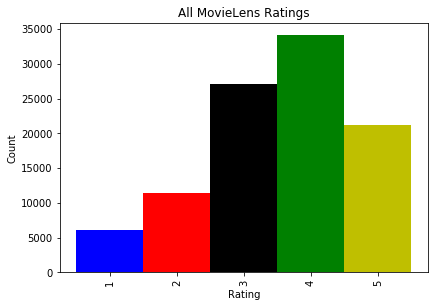

In [5]:
hist_vals = data_df["Rating"].value_counts().sort_index()
hist_vals.plot(kind="bar", width=1.0, color=['b', 'r', 'k', 'g', 'y'])
plt.tight_layout(); plt.xlabel("Rating"); plt.ylabel("Count");
plt.title('All MovieLens Ratings');

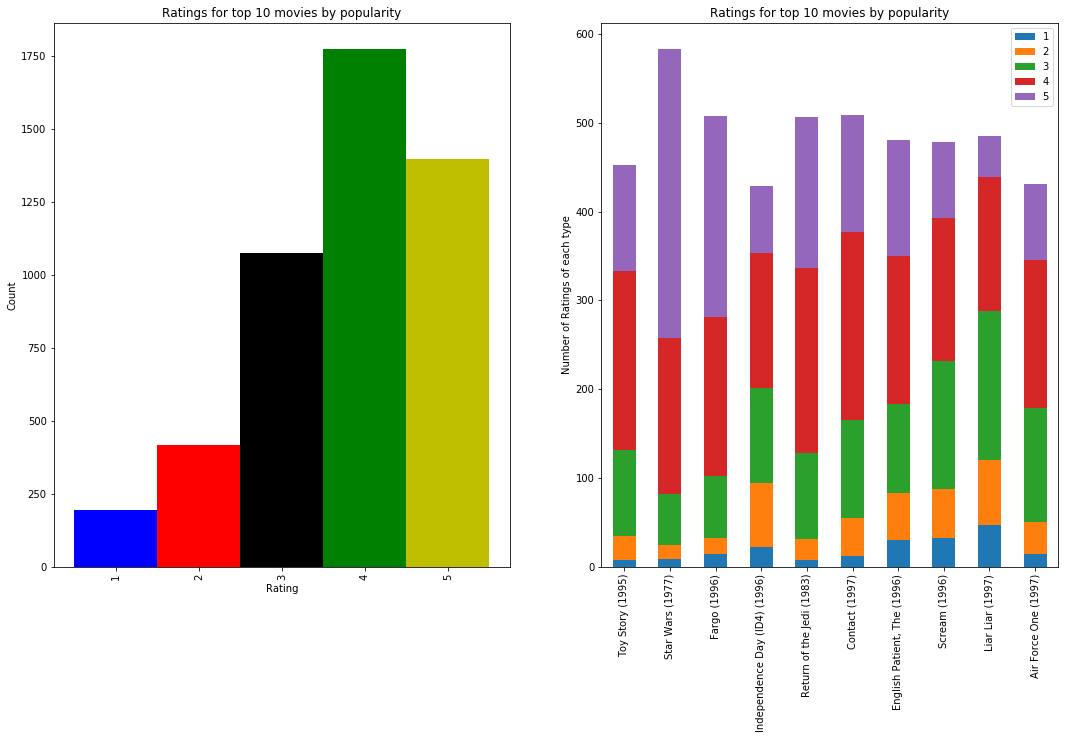

In [6]:
nMovies = 10
pop_movs = data_df["Movie Id"].value_counts()[:nMovies].index
pop_df = data_df.loc[data_df["Movie Id"].isin(pop_movs), :]

# histogram the ratings
ax = plt.subplot(121)
hist_vals = pop_df["Rating"].value_counts().sort_index()
hist_vals.plot(kind="bar", width=1.0, ax=ax, color=['b', 'r', 'k', 'g', 'y'])
ax.set_xlabel("Rating"); ax.set_ylabel("Count");
ax.set_title(f'Ratings for top {nMovies} movies by popularity');

ax = plt.subplot(122)
titles, vals = [], []
for Id, sub_df in pop_df.groupby("Movie Id"):
    titles.append(movie_df.loc[movie_df["Movie Id"] == Id, "Movie Title"].values[0])
    vals.append(sub_df["Rating"].value_counts().sort_index().values)
df = pd.DataFrame(index = titles, data = np.array(vals), columns = np.arange(1, 6))
df.plot(kind='bar', stacked=True, ax = ax)
ax.set_ylabel("Number of Ratings of each type");
ax.set_title(f'Ratings for top {nMovies} movies by popularity');


plt.gcf().set_size_inches(18, 10)

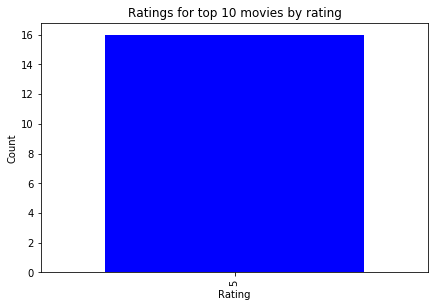

In [7]:
nMovies = 10
av_ratings = data_df.groupby("Movie Id").aggregate('mean')
sort_ratings = av_ratings.sort_values(by='Rating', axis='index', ascending=False)
best_movs = sort_ratings[:nMovies].index
ratings = data_df.loc[data_df["Movie Id"].isin(best_movs), "Rating"]

# histogram the ratings
hist_vals = ratings.value_counts().sort_index()
hist_vals.plot(kind="bar", width=1.0, color=['b', 'r', 'k', 'g', 'y'])
plt.tight_layout(); plt.xlabel("Rating"); plt.ylabel("Count");
plt.title(f'Ratings for top {nMovies} movies by rating');

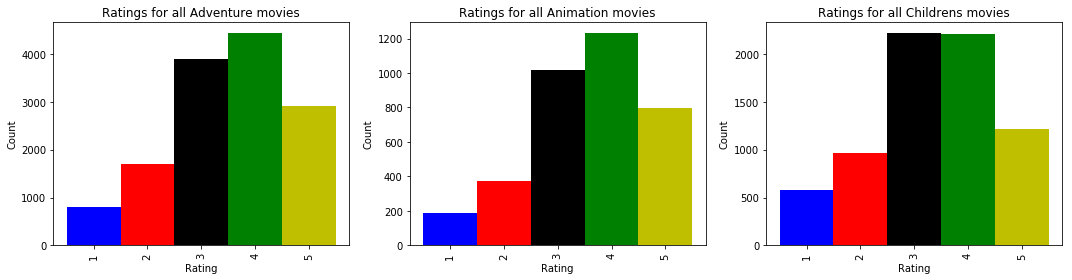

In [8]:
genres = ["Adventure", "Animation", "Childrens"]
fig, axes = plt.subplots(1, len(genres), figsize = (5 * len(genres), 4))

for ax, genre in zip(axes, genres):
    ids = movie_df.loc[movie_df[genre] == 1, "Movie Id"]
    ratings = data_df.loc[data_df["Movie Id"].isin(ids), "Rating"]
    hist_vals = ratings.value_counts().sort_index()
    hist_vals.plot(kind="bar", width=1.0, color=['b', 'r', 'k', 'g', 'y'], ax=ax)
    ax.set_xlabel("Rating"); ax.set_ylabel("Count");
    ax.set_title(f'Ratings for all {genre} movies');
    
plt.tight_layout();